In [18]:
# switch to main dir to fix imports
import os
if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    print("using project root as working dir")

In [19]:
from dataclasses import asdict
from datetime import datetime
import time
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glob
import torch
from tqdm.notebook import tqdm
import numpy as np

from src.evaluator import Evaluator
from src.args import Args
import src.graphs as graphs

In [20]:
# start autoreload
%load_ext autoreload
%autoreload 2

# select device
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"using {device} device")

# global seaborn settings
sns.set_context("paper")
sns.set_style("darkgrid", {"grid.color": ".8"})
palette = "Dark2"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
using cuda device


# Load data frames


In [ ]:
# load data frame from folder
path = "./out/load"
files = glob.glob(os.path.join(path, "*.csv.zip"))
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

# either replace or concat
result = df
#df_result = pd.concat((df_result, df), ignore_index=True)

In [15]:
# save data frame
result.to_csv(os.path.join(path, "./out/saved.csv.zip"), index=False, compression=dict(method='zip', archive_name=f"data.csv"))

OSError: Cannot save file into a non-existent directory: 'out/load/out'

# Test effects of threshold stopping on RGG

In [7]:
# 1. configure experiment
args_list = [
    Args(
        subgraph_alpha=0.15,
        subgraph_size=500,
        threshold_stopping=False,
    )
]
experiment_key = f"stopping-rgg-rjs--{datetime.now().strftime('%d-%m--%H-%M')}"
repetitions = 20

In [12]:
# 2. define how to evaluate
def evaluate(args: Args, rep: int) -> pd.DataFrame:
        graph = graphs.gen_graph(args)
        evaluator = Evaluator(
            graph=graph,
            args=args,
            writer_log_dir=f"runs/{experiment_key}/{args.graph_type}--{args.__hash__()}--{rep}",
            device=device
        )
        # train the model
        return evaluator.train(
            optimizer=torch.optim.Adam(evaluator.net.parameters(), lr=1e-3),
            pbar=False,
            track=True
        )

In [13]:
# 3. run experiment
result = pd.DataFrame({})
for args, rep in tqdm([
    (args, rep)
    for args in args_list
    for rep in range(repetitions)
]):
    res = evaluate(args, rep)
    result = pd.concat([result, res], ignore_index=True)
    result.to_csv(f"./out/{experiment_key}.csv.zip", index=False, compression=dict(method='zip', archive_name=f"data.csv"))

  0%|          | 0/20 [00:00<?, ?it/s]

# Plot results

/tmp/ipykernel_6290/541160587.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(


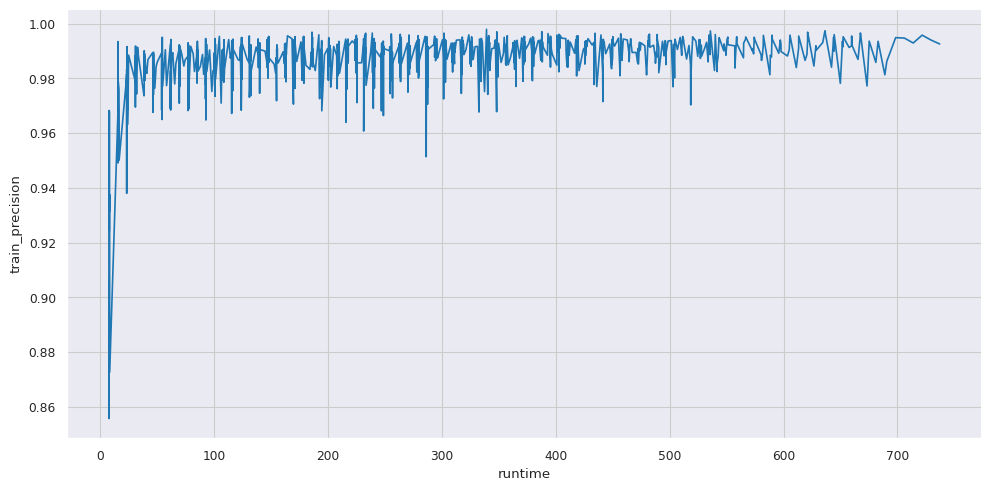

In [34]:
sns.relplot(
    data=result,
    kind="line",
    x="runtime",
    y="train_precision",
    errorbar="sd",
    palette=palette,
    aspect=2,
)

/tmp/ipykernel_6290/4130059583.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.relplot(


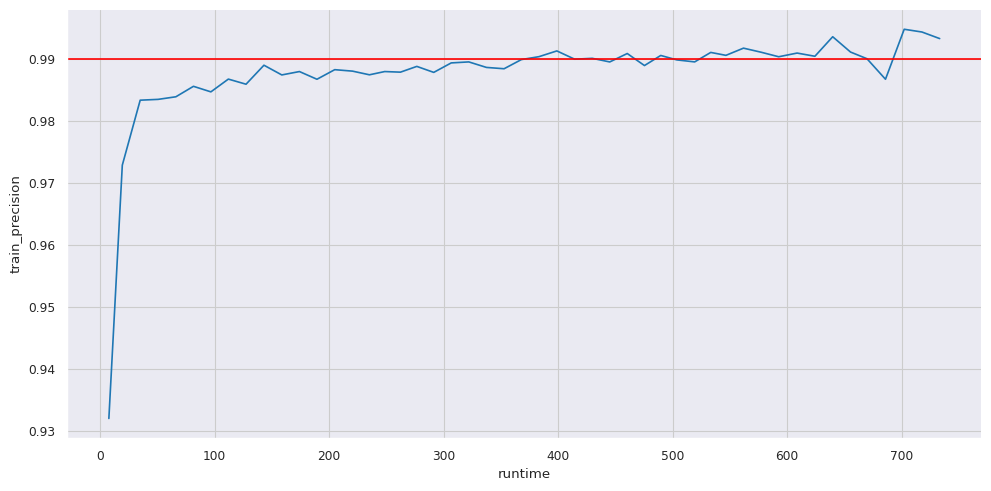

In [63]:
bins = np.linspace(0, result["runtime"].max(), 50)
results_binned = result.groupby(pd.cut(result["runtime"], bins)).mean()

g = sns.relplot(
    data=results_binned,
    kind="line",
    x="runtime",
    y="train_precision",
    errorbar="sd",
    palette=palette,
    aspect=2,
)
g.ax.axhline(.99, color='red')